Steps:  
* [Bin the country/language variables](#Bin-the-country/language-variables)
* [Bin the age variables](#Bin-the-age-variables)
* [Group/bin income variables](#Group/bin-income-variables)
* [Drop dupes of education](#Drop-dupes-of-education)
* [Bin number of people in household](#Bin-number-of-people-in-household)
* [Consider date variables - bin by season?](#Date-variables)
* [Bin hours worked variables](#Bin-hours-worked)
* [Convert year came to country to indicator](#Year-came-to-country)
* [Create single indicator](#Single-indicator)
* [Create "has employees" indicator](#Employee-indicator)
* [Revisit missing](#Remaining-missing-values)
* [One-hot/Label Encoding](#Onehot/label-encoding)
* [Export](#Export-data)

In [2]:
# Import packages
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import statistics
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pycountry_convert as pc
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
# Import data
train = pd.read_csv("../01-data/train.csv", low_memory = False)
test = pd.read_csv("../01-data/test.csv", low_memory = False)

# Custom data
codebook = pd.read_csv("../01-data/codebook_compact.csv", low_memory = False) # OG codebook+dtypes from codebook_long

### Bin the country/language variables

In [4]:
# Dealing with country vars on a case-by-case basis
cat_cols = ['v17', "v20", "v25", "v78", "v154", "v155", "v161", "cntry"]
cat_df = train[cat_cols]

In [5]:
## V17: Country of Birth

# Drop 99, 2, 4, 3, 77, 6
to_drop = ['99', '2', '4', '3', '77', '6', '88']
train['v17'] = train['v17'].replace(to_drop, "-1")
train['v17'] = train['v17'].replace('66', "0")

def convert_country(country):
    try:
        return(pc.country_alpha2_to_continent_code(country))
    except:
        return(country)

train['v17'] = train['v17'].apply(lambda x: convert_country(x))

# Only one observation is from TL, and none exist in the test set. Drop ID = 2441
train = train[train.v17 != 'TL']
train['v17'].value_counts()

0     26687
EU     1925
AS      537
AF      433
-1      229
SA      144
NA      113
OC       11
Name: v17, dtype: int64

In [6]:
train['v17'].isna().sum()

0

In [7]:
### Ignore b/c it is the #4 most important var in the lightgbm

## V20: Region 

# Country code + more specific region code. Convert to just country
# After stripping specific region code, only 6% of obs have a different entry here than for 'cntry'. Drop this column.
# train = train.drop('v20', axis = 1)

In [8]:
## V25: Citizenship

# Drop 65, 99, 6, convert rest to continents
to_drop = ['65', '99', '6', '88']
train['v25'] = train['v25'].replace(to_drop, '-1')
train['v25'] = train['v25'].replace('66', "0")
train['v25'] = train['v25'].apply(lambda x: convert_country(x))
train['v25'].value_counts()

0     28514
EU      955
-1      280
AS      132
AF      118
SA       47
NA       29
OC        4
Name: v25, dtype: int64

In [9]:
train['v25'].isna().sum()

0

In [10]:
## V78: Country of birth, father AND V161: Country of birth, mother

# Drop errors, convert rest to continents
to_drop = ['99', '88', '2', '4', '3', '77', '6']
train['v78'] = train['v78'].replace(to_drop, '-1')
train['v78'] = train['v25'].replace('66', "0")
train['v78'] = train['v78'].apply(lambda x: convert_country(x))

train['v161'] = train['v161'].replace(to_drop, '-1')
train['161'] = train['v161'].replace('66', "0")
train['v161'] = train['v161'].apply(lambda x: convert_country(x))

In [11]:
train['v78'].isna().sum()

0

In [12]:
train['v161'].isna().sum()

0

In [13]:
## V154: Language most often spoken at home: first mentioned

# Drop errors
to_drop = ['999','888','777']
train['v154'] = train['v154'].replace(to_drop, '-1')

# Leaving ENG and GER as is 
missing = ["."]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO"]
bal = ["CZE", "LIT"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE"]
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON"]

languages = {language: 'EUR' for language in eur}
languages.update({language: '-1' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

train['v154'] = train['v154'].map(languages)

train['v154'].value_counts(normalize = True)

EUR        0.262502
NOR        0.205021
GER        0.121296
ENG        0.117006
SLAV       0.114895
BAL        0.107521
MIDEAST    0.066396
SOUTHA     0.001910
AFR        0.001508
OTHER      0.001039
ASIA       0.000905
Name: v154, dtype: float64

In [14]:
train['v154'] = train['v154'].fillna(-1).astype(str)

In [15]:
train['v154'].isna().sum()

0

In [16]:
## V155: Language most often spoken at home: second mentioned

# Assuming 0 means no other language, and 999, 888, 777 are missing
to_drop = ['999','888','777']
train['v155'] = train['v155'].replace(to_drop, '-1')

## Check if any weren't present in the previous question
lang_v154 = ["GER","ENG","FRE","CZE","LIT","FIN","POL","DUT","SWE","HEB","SPA",
             "HUN","DAN","NOR","POR","EST","SLV","RUS","GSW","ARA","CAT","TUR",
             "ITA","GLG","SRP","BOS","ALB","FRS","RUM","KUR","HRV","BAQ","URD",
             "PER","AMH","APA","ROA","CHI","HIN","ARM","GLE","SOM","SLO","IRA",
             "TAM","GEM","GUJ","ROM","CPP","FRM","GRE","WEL","VIE","BUL","UKR",
             "YID","BER","PAP","MIS","BEN","SLA","LAV","MAL","THA","TGL","NEP",
             "MAY","SYR","AZE","UZB","PAN","TGK","MLG","ROH","TIR","MAN","TAI",
             "LIN","KAB","EGY","BEL","WOL","BAM","TIB","AKA","SWA","IND","SUX",
             "TEL","FAO","JPN","SRN","SUS","ICE","SNK","FIL","ABK","GEO","TIG",
             "NAP","AST","FRO","LAO","CPF","MON","MDR"]

lang_v155 = train['v155'].unique().tolist()

new_languages = [language for language in lang_v155 if language not in lang_v154]

# New language dict: leaving ENG and GER as is 
none = ['0']
missing = ["-1"]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO","ENM","OCI","BRE",
       "NDS","WLN","VOL","MWL"]
bal = ["CZE", "LIT", "MAC", "CSB"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG",
       "EWE","RUN","IBO","YOR","FON","KON","DYU","KIN","NIC","NDE","HER","KIK"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE", 'SMN']
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF", "MAR"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON","ZXX","TPI","GRN","SGN","HUP","NAH","HAT","CAD","PHI","MAO"]

 
languages = {language: 'EUR' for language in eur}
languages.update({language: '0' for language in none})
languages.update({language: '-1' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

# Map langauges to their groups
train['v155'] = train['v155'].map(languages)

train['v155'].value_counts(normalize = True)

0          0.792447
-1         0.061604
EUR        0.041158
ENG        0.027827
NOR        0.021510
SLAV       0.019449
MIDEAST    0.017388
GER        0.012002
BAL        0.002161
AFR        0.001662
OTHER      0.001130
ASIA       0.000831
SOUTHA     0.000831
Name: v155, dtype: float64

In [17]:
train['v155'].isna().sum()

0

In [18]:
train['cntry'].isna().sum()

0

### Bin the age variables

In [19]:
## V3: Age of respondent, calculated

missing_age = round(len(train[train['v3'] == '.a'])/len(train) * 100, 2)
print(str(missing_age) + "% of the ages are missing.")

0.24% of the ages are missing.


In [20]:
# Using EDA notebook, the highest positive and negatively linearly correlated vars with Age (v3):
# Positive: v217, v163, v218, v103, v99
# Negative: v54, v196, v208, v100, v159	
cols = ['v3','v217','v218', 'v54']

regress_age = train[cols]
train_lr = regress_age[regress_age['v3'] != '.a']
test_lr = regress_age[regress_age['v3'] == '.a']

for col in cols:
    train_lr[col] = pd.to_numeric(train[col], errors = 'coerce')

# Drop all na
train_lr = train_lr.dropna()

X_train = train_lr.loc[:, train_lr.columns != 'v3']
y_train = train_lr['v3']

# Linear regression
regressor = lgb.LGBMRegressor()  
regressor.fit(X_train, y_train) 

del test_lr['v3']
test_lr = test_lr.replace(['.a', '.b', '.c', '.d'], np.nan).dropna()

test_lr["predicted_age"] = regressor.predict(test_lr)

# Gives R2 score of 0.63 but better than imputation by mean
# metrics.r2_score(label, train_no_na["predicted_age"])

In [21]:
# Filling in missing values with predicted age
index_predicted = test_lr.drop(['v217','v218', 'v54'], axis = 1).index
index_missing = train[train['v3'] == '.a'].index

train = train.join(test_lr['predicted_age'])
train['v3_imputed'] = np.where(train['v3'] == '.a', train['predicted_age'], train['v3']).astype("float64")
# Delete other versions of age
del train['v3']
del train['predicted_age']

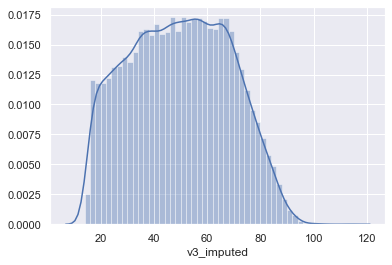

In [22]:
# Plot age distribution
sns.set(color_codes=True)
sns.distplot(train['v3_imputed'].astype("float64"));

# (37.0, 44.0]
# (23.0, 31.0]
# (44.0, 50.0]
# (61.0, 67.0]
# (55.0, 61.0]
# (13.999, 23.0]
# (74.423, 114.0]
# (67.0, 74.423]
# (31.0, 37.0]
# (50.0, 55.0]

bin_labels = [1,2,3,4,5,6,7,8,9,10]
train['v3_binned'] = pd.qcut(train['v3_imputed'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

del train['v3_imputed']

### Group/bin income variables

In [23]:
# Drop v102 as it is almost the same as v103 but with less information
del train['v102']

### Drop dupes of education

In [24]:
# Drop v57, v59, v61, v63 as v56, v58, v60, v62 gives the same information but mapped to categories
del train['v57']
del train['v59']
del train['v61']
del train['v63']

0.93% of the years are missing.


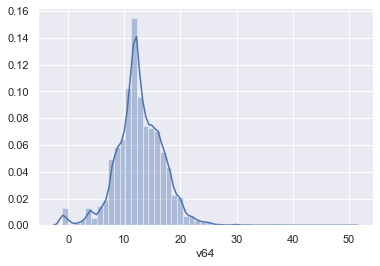

In [25]:
# V64: Years of full time education completed

# Combine all missing
train['v64'] = pd.to_numeric(train['v64'], errors='coerce')

missing_age = round(len(train[train['v64'].isnull()])/len(train) * 100, 2)
print(str(missing_age) + "% of the years are missing.")

# Plot distribution
sns.distplot(train['v64'].fillna(-1));



In [26]:
# Fill with mean bc I'm tired
train['v64'] = pd.to_numeric(train['v64'], errors = 'coerce')
mean_years = np.nanmean(train['v64'])
train['v64'] = train['v64'].fillna(mean_years)

In [27]:
## Now bin education
train['v64'].describe()

bin_labels = [1,2,3,4,5]
train['v64_binned'] = pd.qcut(train['v64'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

In [28]:
train['v64_binned'].value_counts()
del train['v64']

### Bin number of people in household

In [29]:
## V100: Number of people living regularly as member of household
# Group everything more than 6 into "6+", i.e. 6

# Combine all missing
train['v100'] = pd.to_numeric(train['v100'], errors='coerce')

missing_age = round(len(train[train['v100'].isnull()])/len(train) * 100, 2)
print(str(missing_age) + "% of the numbers are missing.")

# Fill with mean
mean_years = np.nanmean(train['v100'])
train['v100'] = train['v100'].fillna(mean_years).astype("int64")

# Grouping large values
train['v100_grouped'] = np.where(train['v100'] > 6, 6, train['v100']).astype("int64")
train['v100_grouped'].value_counts()

0.28% of the numbers are missing.


2    10553
1     6387
3     5414
4     4894
5     1829
6     1002
Name: v100_grouped, dtype: int64

### Date variables

Create start/end time_of_day, season, and bin interview length (minutes)

In [30]:
# v128: End of interview, month
# v129: Start of interview, month
# End and start of interview are only not equal for 0.18% of observations
# We keep v129 since there are no missing
del train['v128']

# Define: 3-5 = Spring, 6-8 = Summer, 9-11 = Autumn, 12-2 = Winter - in Germany
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]

# Dictionary for seasons
seasons = {season: 'WI' for season in winter}
seasons.update({season: 'SP' for season in spring})
seasons.update({season: 'SU' for season in summer})
seasons.update({season: 'AU' for season in autumn})

# Map langauges to their groups
train['start_interview_season'] = train['v129'].map(seasons)
train['start_interview_season'].value_counts(normalize = True)

# Delete original variable
del train['v129']

In [31]:
# v126: end of interview, hour
# v130: start of interview, hour

# Impute with mean
train['v126'] = pd.to_numeric(train['v126'], errors='coerce')
train['v126'] = train['v126'].fillna(np.nanmean(train['v126'])).astype('int64')
train['v130'] = pd.to_numeric(train['v130'], errors='coerce')
train['v130'] = train['v130'].fillna(np.nanmean(train['v130'])).astype('int64')

bin_labels = [1,2,3,4,5]
train['v126_binned'] = pd.qcut(train['v126'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)
train['v130_binned'] = pd.qcut(train['v130'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

# Delete original variables
del train['v126']
del train['v130']

In [32]:
# v132: Interview length in minutes - bin in quantiles
bin_labels = [1,2,3,4,5,6,7,8,9,10]
train['v132_binned'] = pd.qcut(train['v132'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

# Delete original variable
del train['v132']

### Bin hours worked

In [33]:
# v250: Total contracted hours per week in main job OT excluded
train['v250'] = pd.to_numeric(train['v250'], errors = 'coerce')
train['v250_binned'] = pd.cut(train['v250'], 4, labels=[1,2,3,4])

del train['v250']

# v251: Total hours normally worked per week main job OT included
train['v251'] = pd.to_numeric(train['v251'], errors = 'coerce')
train['v251_binned'] = pd.cut(train['v251'], 4, labels=[1,2,3,4])

del train['v251']

# v251: Total hours normally worked per week main job OT included - partner
train['v252'] = pd.to_numeric(train['v252'], errors = 'coerce')
train['v252_binned'] = pd.cut(train['v252'], 4, labels=[1,2,3,4])

del train['v252']

In [34]:
train['v252_binned'].value_counts()

1    7836
2    2552
3      34
4      11
Name: v252_binned, dtype: int64

In [35]:
# v168: Number of people responsible for in job

train['v168'] = pd.to_numeric(train['v168'], errors = 'coerce')
train['v168'] = train['v168'].fillna(0).astype('int64')

# Define:
none = [0]
few = [1,2,3,4,5,6,7,8,9,10]
moderate = [11,12,13,14,15,16,17,18,19,20]
many = range(21, max(train['v168']))

# Dictionary for seasons
people = {people: 0 for people in none}
people.update({people: 1 for people in few})
people.update({people: 2 for people in moderate})
people.update({people: 3 for people in many})

# Map langauges to their groups
train['manage'] = train['v168'].map(people)
train['manage'].value_counts(normalize = True)

# Delete original variable
del train['v168']

### Year came to country

In [36]:
train['v153'] = pd.to_numeric(train['v153'], errors = 'coerce')
train['v153'] = train['v153'].fillna(0).astype('int64')

# Define:
na = [0]
before_80 = range(1, 1980)
after_80 = range(1981, max(train['v153']))

# Dictionary for seasons
immigrate = {immigrate: 0 for immigrate in na}
immigrate.update({immigrate: 1 for immigrate in before_80})
immigrate.update({immigrate: 2 for immigrate in after_80})

# Map langauges to their groups
train['immigrate'] = train['v153'].map(immigrate)
train['immigrate'].value_counts(normalize = True)

# Delete original variable
del train['v153']

### Single indicator

In [37]:
train['single'] = np.where(train['v164'] == '.a', 1, 0)

### Employee indicator

In [38]:
dots = ['.a', '.b', '.c', '.d']
train['employees'] = np.where(np.isin(train['v69'], dots) , 0, 1)

### Remaining missing values

Same as before, we find columns with over some % '.' variables and drop them

In [39]:
# Convert binned vars to int to fillna
binned = ["v3_binned","v64_binned", "v126_binned", "v130_binned", "v132_binned", 
          "v250_binned", "v251_binned", "v252_binned"]

for col in binned:
    train[col] = train[col].astype('int64')

In [40]:
train = train.fillna(".")

In [41]:
# convert cat vars to dtype 'categorical'
train[cat_cols] = train[cat_cols].astype('category')
train.dtypes

id                           int64
v1                          object
v2                          object
v4                          object
v5                          object
v6                          object
v7                          object
v8                          object
v9                          object
v10                         object
v11                         object
v12                         object
v13                         object
v14                         object
v15                          int64
v16                          int64
v17                       category
v18                         object
v19                         object
v20                       category
v21                         object
v22                         object
v23                         object
v24                         object
v25                       category
v26                          int64
v27                          int64
v28                          int64
v29                 

In [42]:
# Treating missing 
train_copy = train.copy()
train_nodots = train_copy.replace([".", ".a", ".b", ".c", ".d"], [np.nan, np.nan, np.nan, np.nan, np.nan])
percent_missing_nodots = train_nodots.isnull().sum() * 100 / len(train_nodots)
missing_value_df_nodots = pd.DataFrame({'column_name': train_nodots.columns,
                                 'percent_missing': percent_missing_nodots})

# Columns where % missing > some percent
percent = 30
cols_missing = missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent]
n_cols_missing = len(missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent])
print("There are " + str(n_cols_missing) + " features with over " + str(percent) + "% missing.")

# Attach short desc for more context
codebook_labels = ['Variable', "Label"]
missing = cols_missing.merge(codebook[codebook_labels], left_on = 'column_name', right_on = "Variable", how = "left")
missing.sort_values(by = "percent_missing", ascending = False)

There are 67 features with over 30% missing.


,column_name,percent_missing,Variable,Label
59,v262,99.996675,v262,Year of birth of thirteenth pe...
45,v207,99.996675,v207,Thirteenth person in household...
11,v89,99.996675,v89,Gender of thirteenth person in...
34,v195,99.996675,v195,Thirteenth person in household...
58,v261,99.983377,v261,Year of birth of twelfth perso...
10,v88,99.983377,v88,Gender of twelfth person in ho...
33,v194,99.980053,v194,Twelfth person in household: r...
44,v206,99.980053,v206,Twelfth person in household: r...
57,v260,99.940158,v260,Year of birth of eleventh pers...
9,v87,99.933508,v87,Gender of eleventh person in h...


In [43]:
# Drop -
drop_missing = ['v22','v23','v69','v86','v87','v88','v89','v91','v92','v93','v94','v95','v96','v97',
                'v123','v164','v174','v191','v192','v193','v194','v195','v197','v198','v199','v200',
                'v201','v202','v203','v204','v205','v206','v207','v209','v210','v211','v212','v213',
                'v214','v215','v259','v260','v261','v262','v264','v265','v266','v267','v268','v269',
                'v270',]
# train_dropped = train_nodots.drop(drop_missing, axis = 1)
train_dropped = train.drop(drop_missing, axis = 1)

# Impute the rest
# dots = [".", ".a", ".b", ".c", ".d", np.nan]
# train_imputed = train_dropped.replace(dots, [-1, -1, -1, -1, -1, -1])

In [44]:
train_dropped['v158'].value_counts()

.a    25935
1      1949
6       757
8       651
2       377
5       137
3       121
4        46
.d       39
9        36
.c       26
7         5
Name: v158, dtype: int64

In [45]:
train_dropped['v158'].isnull().sum()

0

In [46]:
# v158 : Main activity last 7 days - bin into working, not working, other
to_drop = ['.a','.d','b','.c']
train_dropped['v158'] = train_dropped['v158'].replace(to_drop, 9)

train_dropped['v158'] = pd.to_numeric(train_dropped['v158'], errors = 'coerce')
train_dropped['v158'] = train_dropped['v158'].fillna(0).astype('int64')

# Define:
paid_work = [1]
unpaid_work = [8,2,7]
not_working = [6,5,3,4]
other = [9]

# Dictionary for activity
activity = {activity: 0 for activity in other}
activity.update({activity: 1 for activity in paid_work})
activity.update({activity: 2 for activity in unpaid_work})
activity.update({activity: 3 for activity in not_working})

# Map langauges to their groups
train_dropped['main_activity'] = train_dropped['v158'].map(activity)
train_dropped['main_activity'].value_counts(normalize = True)

# Delete original variable
del train_dropped['v158']

In [48]:
# v241 : Any period of unemployment and work seeking lasted 12 months or more
train_dropped['v241'] = train_dropped['v241'].replace('.a', 0)
train_dropped['v241'] = train_dropped['v241'].replace(['.b','.c','.d'], -1)
train_dropped['v241'] = pd.to_numeric(train_dropped['v241'], errors = 'coerce')
train_dropped['v241'] = train_dropped['v241'].fillna(-1).astype('int64')
train_dropped['v241'].value_counts()

In [50]:
# v243 : Any period of unemployment and work seeking lasted 5 years or more
train_dropped['v243'] = train_dropped['v243'].replace('.a', 0)
train_dropped['v243'] = train_dropped['v243'].replace(['.b','.c','.d'], -1)
train_dropped['v243'] = pd.to_numeric(train_dropped['v243'], errors = 'coerce')
train_dropped['v243'] = train_dropped['v243'].fillna(-1).astype('int64')
train_dropped['v243'].value_counts()

 0    21534
 2     4433
 1     4066
-1       46
Name: v243, dtype: int64

In [51]:
# v5 : Second ancestry, European Standard Classification of Cultural and Ethnic Groups
train_dropped['v5'] = train_dropped['v5'].replace('.a', 0)
train_dropped['v5'] = train_dropped['v5'].replace(['.b','.c','.d'], -1)
train_dropped['v5'] = pd.to_numeric(train_dropped['v5'], errors = 'coerce')
train_dropped['v5'] = train_dropped['v5'].fillna(-1).astype('int64')
train_dropped['v5'].value_counts()

 0         19423
-1          1834
 12060      1028
 25070       705
 11010       695
 22000       631
 11050       592
 11030       491
 13070       407
 13071       214
 11070       205
 15080       186
 15110       184
 13990       182
 15111       175
 444444      146
 13040       137
 11031       116
 11102       113
 15090       111
 21220       107
 13060        97
 11100        94
 11081        92
 21000        87
 22011        83
 21150        81
 15140        77
 11051        73
 15020        70
 12020        62
 11040        57
 15130        53
 10000        52
 14100        50
 21130        50
 15010        48
 15060        46
 13075        46
 11101        43
 14040        41
 15040        40
 11080        39
 15120        36
 11058        36
 12040        36
 13074        35
 13010        32
 11033        31
 11020        31
 22013        29
 61050        28
 22012        25
 15030        25
 14110        25
 14090        25
 23000        24
 21010        24
 43020        

In [ ]:
# quick fix
train_imputed['v252_binned'] = np.where(train_imputed['v252_binned'] < 1, 0, train_imputed['v252_binned'])
train_imputed['v251_binned'] = np.where(train_imputed['v251_binned'] < 1, 0, train_imputed['v251_binned'])
train_imputed['v250_binned'] = np.where(train_imputed['v250_binned'] < 1, 0, train_imputed['v250_binned'])

### One-hot/Label encoding

In [ ]:
one_hot = ['v17','v25','v78','v161', 'v154', 'v155', 'start_interview_season']
train_encoded = pd.get_dummies(train_imputed, prefix=one_hot, columns=one_hot)

In [ ]:
# Label encode country
label_encoder = preprocessing.LabelEncoder()
train_encoded['cntry'] = label_encoder.fit_transform(train_encoded['cntry'])
train_encoded['v20'] = label_encoder.fit_transform(train_encoded['v20'])
    
# Convert all other variables to int64
num_cols = train_encoded.loc[:, ~train_encoded.columns.isin(['cntry', 'v20'])].columns.tolist()
train_encoded[num_cols] = train_encoded[num_cols].astype("int64")

### Export data

In [ ]:
train_encoded.to_csv("train_FE.csv")